## **Tarea Práctica** - Regresion Polinomial & Feature Engineering

#### Librerias a utilizar

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta
import math

In [2]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


### **Parte 1**

#### Carga de Datos

In [3]:
data_covid = pd.read_csv('covid_19.csv')

#### Fauture Engineering

In [293]:
data_covid["Date"] = pd.to_datetime(data_covid["Date"], infer_datetime_format = True)
data_filtered = data_covid[(data_covid["Country/Region"] == 'Guatemala') & (data_covid["Confirmed"] > 0) & (data_covid["Date"]>="2020-03-22")].copy()
data_filtered["Confirmed_converted"] = np.log(data_filtered["Confirmed"])
data_filtered["Count_days"] = max(data_filtered["Date"])-data_filtered["Date"]
data_filtered["Number_day"] = pd.to_timedelta(max(data_filtered["Count_days"])-data_filtered["Count_days"]).dt.days

In [295]:
data_filtered.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Confirmed_converted,Count_days,Number_day
16023,NaN,Guatemala,15.7835,-90.2308,2020-03-22,19,1,0,2.944439,58 days,0
16288,NaN,Guatemala,15.7835,-90.2308,2020-03-23,20,1,0,2.995732,57 days,1
16553,NaN,Guatemala,15.7835,-90.2308,2020-03-24,21,1,0,3.044522,56 days,2
16818,NaN,Guatemala,15.7835,-90.2308,2020-03-25,24,1,4,3.178054,55 days,3
17083,NaN,Guatemala,15.7835,-90.2308,2020-03-26,25,1,4,3.218876,54 days,4


#### Definición de clases para la construcción del Modelo de Regresión Lineal

In [286]:
class Linear_regression:
    
    def __init__(self):
        tf.reset_default_graph()
        self.values = np.array([0.1,2.2])
        init = tf.constant_initializer(self.values)
        self.parameters_vector = tf.get_variable("parameters", dtype=tf.float32, shape=[2,1], initializer=init)
        
    def cost(self, y_train, y_predict):
        with tf.name_scope("cost"):
            return 1/2*tf.reduce_mean(tf.math.square(y_train - y_predict))
    
    def predict(self, x):
        with tf.name_scope("predict"):
            ones = tf.cast(tf.ones_like(x), tf.float32)
            return tf.matmul(tf.stack((x,ones), axis=-1), self.parameters_vector)
    
    def gradient(self, error_cost, y_train, y_predict):
        return tf.gradients(error_cost, self.parameters_vector)
    
    def update_parameters(self, error_cost, y_train, y_predict, learning_rate):
        with tf.name_scope("gradient"):
            gradient_vector = self.gradient(error_cost, y_train, y_predict)
        with tf.name_scope("update_params"):
            return tf.assign(self.parameters_vector, self.parameters_vector - learning_rate*gradient_vector[0])

In [296]:
class Linear_model:
    
    def __init__(self, array):
        self.tamano_data_set = len(array)        
        self.lr = Linear_regression()
        self.params = self.lr.values
        self.x = array["Number_day"].to_numpy()/10
        self.y = array["Confirmed_converted"].to_numpy()

    def training(self, learning_rate, steps):
        plt.scatter(self.x,self.y)
        x_train = tf.placeholder(tf.float32,[self.tamano_data_set],"x_train")
        y_train = tf.placeholder(tf.float32,[self.tamano_data_set],"y_train")

        y_predict = self.lr.predict(self.x)
        error = self.lr.cost(y_train, y_predict)
        update_parameters_vector = self.lr.update_parameters(error, y_train, y_predict, learning_rate)

        with tf.train.MonitoredSession() as session:
            feed_dict = {x_train:self.x, y_train:self.y}
            for step in range(steps):
                session.run(update_parameters_vector,feed_dict=feed_dict)
                prediction = session.run(y_predict,feed_dict=feed_dict)
                plt.plot(self.x,prediction)
            self.params = session.run(self.lr.parameters_vector,feed_dict=feed_dict)
            plt.title("Parámetros finales: m={} b={}".format(self.params[0],self.params[1]))

        plt.legend()
        plt.show()

#### Objeto de la clase ***Linear_model***

In [297]:
lm = Linear_model(data_filtered)

#### Gráfica de Dispersión

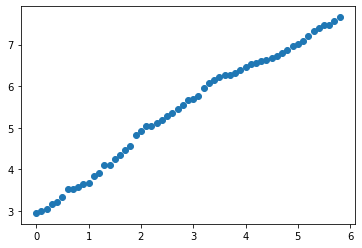

In [298]:
plt.scatter(lm.x,lm.y)
plt.show()

#### Entrenamiento del Modelo con lr=0.0025 y 160 iteraciones

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


No handles with labels found to put in legend.


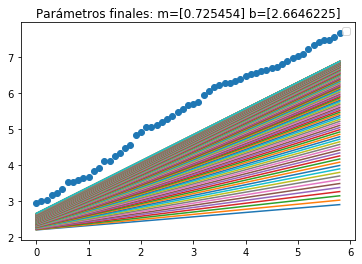

In [299]:
lm.training(0.0025, 160)

#### Función ***get_number_day***

Esta función fue desarrollada con la intención de experimentar con cualquier fecha devolviendo su equivalente en número entero.

In [291]:
def get_number_day(date, data):    
    return max(pd.to_timedelta(datetime.strptime(date, "%Y-%m-%d") - data["Date"]).dt.days)

#### Predicción de casos reportados para **2020-06-06**

In [292]:
date_string = "2020-06-06"
number_day = get_number_day(date_string, data_filtered)
model = lm.params[0]*(number_day/10) + lm.params[1]
prediction = int(pow(math.e,model[0]))
print("Se predicen",prediction,"casos confirmados para",date_string)

Se predicen 3561 casos confirmados para 2020-06-06


#### **Conclusión** 

Durante el experimento se observó que si se continuaban incrementando las iteraciones o el learning rate, disminuía la pendiente de la recta dando un menor grado de predicción, se identifico que con esto parametros se lograba una tendencia que podría ajustarse al modelo.